# Sorting k in descending order into g-groups, using two reference (pressure, temperature) 


In [6]:
%matplotlib inline
from IPython import display
import os, sys

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib 
import matplotlib.pyplot as plt


In [7]:
matplotlib.rc('font', size=13)

# O3 band 5 absorption coefficient


In [68]:
# for loading absorption coefficient calculated using line-by-line
# k(v, pt)

def get_data_file_paths():
    
    dir_common = os.path.join('/nuwa_cluster/home/jackyu',
                              'radiation/crd/LW/examples',
                              'separate_g_groups',
                              'study__lblnew_g1_threshold',
                              'o3',
                              'wn_20_3000',
                              'absgas_variousPTs')
    
    dir_runs = ['T__250K_P__10_50_100_500_1e3',
                'T__250K_P__.1_1_5mb']
    
    path_runs = [os.path.join(dir_common, dir_run, 'output_absgas.dat')
                 for dir_run in dir_runs]
    return path_runs



def load_absgas_file(path_absgas):
    df = pd.read_csv(path_absgas, sep=r'\s+')
    df = df.set_index(['v', 'pressure', 'temperature'])
    
    ds = xr.Dataset.from_dataframe(df)
    ds = ds.stack(pt=('pressure', 'temperature'))
    ds.coords['ipt'] = ('pt', range(1, ds.dims['pt'] + 1))
    return ds   
    

    
def load_absgas_files(paths_absgas):
    dss = [load_absgas_file(fpath) for fpath in paths_absgas]
    return xr.concat(dss, dim='pt')



def o3_band5_limits():
    return {'min': 980, 'max': 1100}



def ref_pts():
    return {'low': (50, 250), 'high': (1, 250)}




def get_tworef_dataframe(ds, min_wvn=0, max_wvn=3000, pts=None):
    if pts == None:
        pts = [(50, 250)]
        
    pts = sorted([pt for _, pt in ref_pts().items()],
                 key=lambda x: x[0])
    return ds['absgas'].sel(pt=pts, v=slice(min_wvn, max_wvn))\
           .to_pandas()


In [ ]:
ds = load_absgas_files(get_data_file_paths())

In [70]:
vlims = o3_band5_limits()
pts = [pt for _, pt in ref_pts().items()]

df = get_tworef_dataframe(ds, 
                          min_wvn=vlims['min'],
                          max_wvn=vlims['max'],
                          pts=pts)

In [71]:
df.head()

pressure,1,50
temperature,250,250
v,,
980.001,1.852463e-20,5.806543e-21
980.003,3.134201e-22,4.071877e-21
980.005,8.245442e-23,2.557286e-21
980.007,4.312231e-23,1.698846e-21
980.009,2.852815e-23,1.243706e-21


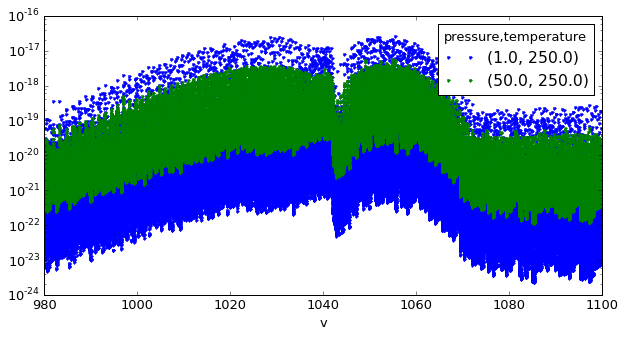

In [31]:
# have a look at the k at the two reference pt's.
df.plot(logy=True, figsize=(10, 5),
        linestyle='None', marker='.')

**Figure 1. O3 Band 5 k(v, pt).**  
Let's say that the absorption coefficient as a function of wavenumber $\nu$ are as shown in the plot.  These have the property that, assuming in the Lorentzian regime, the higher pressure, the smaller the range of k, and the lower the pressure, the larger the range of k. 

In [6]:
# sort series from small to large and then plot
#df_sorted = df.sort_values(by=(1, 250))
#df_sorted = df_sorted.reset_index()
#df_sorted.index.set_names('wavenumer index', inplace=True)

#df_sorted[[(1, 250), (50, 250)]].plot(logy=True, linestyle='None',
#                                      marker='.', figsize=(10, 5))

# Sorting k

In [39]:
def value_bins(absth):
    return np.concatenate(([0], absth[1:-1], [1]), axis=0)



def g_high_inclusive():
    "the lowest g that is from sorting k at pt_high"
    return 7


def ng_tot():
    return 20



def find_ggroup_membership(kdist, absth):
    '''
    Map each spectral point (or wavenumber) to a g-group,
    based on the distribution of k and the g-groups, defined
    by their upper and lower limits.
    '''
    bins = value_bins(absth)
    ng = len(absth) - 1

    return pd.cut(kdist, bins=bins, 
                  labels=range(1, ng + 1), 
                  include_lowest=True,
                  retbins=True)

In [40]:
def plt_sorted_series(srs, absth=None):
    
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(13, 10))

    axs[0].plot(srs.index, srs.values, 
                linestyle='None', marker='.', markersize=2)
    axs[0].set_ylabel('k')
    axs[0].set_yscale('log')
    axs[0].set_xlabel('wavenumber [$cm^{-1}$]')
    
    axs[1].plot(srs.sort_values().values,
                linestyle='None', marker='.', markersize=2)
    axs[1].set_yscale('log')
    plt.setp(axs[1].get_yticklabels(), visible=False)
    axs[1].yaxis.set_tick_params(size=0)
    axs[1].set_xlabel('wavenumber index after sorting k')

    if absth != None:
        axgs = [ax.twinx() for ax in axs]
        axgs[0].get_shared_y_axes().join(*(list(axs) + list(axgs)))
        for v in absth:
            axgs[0].plot(srs.index, v * np.ones(srs.shape), 
                         color='grey', linestyle='--', linewidth=.5)
            axgs[1].plot(v * np.ones(srs.shape), 
                         color='grey', linestyle='--', linewidth=.5)
            
        axgs[0].set_yscale('log')
        axgs[0].yaxis.set_tick_params(size=0)
        plt.setp(axgs[0].get_yticklabels(), visible=False)
            
        axgs[1].set_ylabel('iabsth')
        axgs[1].set_yscale('log')
        axgs[1].set_yticks(absth)
        axgs[1].set_yticklabels(range(1, absth.shape[0] + 1))
        
#    plt.subplots_adjust(wspace=0)
    return fig, axs, axgs if absth != None else None



Let `ng` be the total number of g-groups we look to end up with.  The two reference (pressure, temperature) pairs used are:

- high reference ---- `pt_high`
- low reference ---- `pt_low`

G-groups `g_high_inclusive` to `ng` will be obtained by sorting k using the high reference, while g-groups 1 to (`g_high_inclusive - 1`) will use the low reference.

In this example, the value used are:

In [41]:
print('ng =     ', ng_tot())
print('pt_high =     ', ref_pts()['high'])
print('pt_low =     ', ref_pts()['low'])
print('g_high_inclusive =    ', g_high_inclusive())

ng =      20
pt_high =      (1, 250)
pt_low =      (50, 250)
g_high_inclusive =     7


In [65]:
srs = df[ref_pts()['high']]

absth_high = np.logspace(np.log10(srs.min()), 
                         np.log10(srs.max()), 
                         ng_tot() + 1)

ncut_high = find_ggroup_membership(srs, absth_high)

/nuwa_cluster/home/jackyu/locally_installed_python_pacakges/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:18: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/nuwa_cluster/home/jackyu/locally_installed_python_pacakges/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:37: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


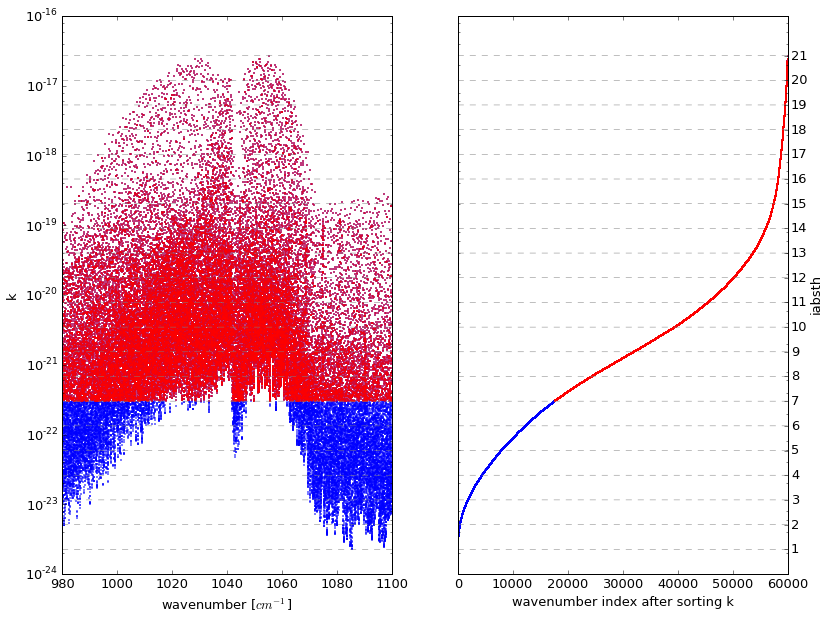

In [66]:
srs = df[ref_pts()['high']]

absth = absth_high



fig, axs, axgs = plt_sorted_series(srs, absth=absth)


# over-plot to indicate wavenumbers in `wvns_high`
wvns_high = ncut_high[0][(ncut_high[0] >= g_high_inclusive())]

srs_sub = srs[wvns_high.index]
axs[0].plot(srs_sub.index, srs_sub.values, 
            color='r', linestyle='None', marker='.', markersize=2)

df_sorted = pd.DataFrame(srs.sort_values())
df_sorted['k-sort index'] = range(srs.shape[0])
df_sorted_sub = df_sorted.loc[wvns_high.index, :]

axs[1].plot(df_sorted_sub['k-sort index'], df_sorted_sub[srs.name].values,
            color='r', linestyle='None', marker='.', markersize=2)

**Figure 1. Absoroption coefficient at high reference.**   
(*left panel*) `k(pt = pt_high)`. (*right panel*) `k(pt = pt_high)` sorted by k.  On the left y-axis are shown the value of the absorption coefficient, k.  The horizontal dashed lines mark the g-groups' edges with the g-group number indicated on the right y-axis.  Everything above `iabsth = 20`, for example, belong to g-group 20, and everything below `iabsth = 2` belong to g-group 1.  The yellow section indicates the wavenumbers where the binning using the high reference will be kept for the final g-groups.  The blue section will be further binned using the low reference.

In [48]:
# There remains ng_low g-group to sort out
ng_low = g_high_inclusive() - 1

In [49]:
# Get the binned results where g < g_high_inclusive

# This gets us the wavenumbers that are not binned 
# in g-group `g_high_inclusive` or higher
wvns_low = ncut_high[0][(ncut_high[0] <= ng_low)]

In [54]:
# Find the range of of k(pt = pt_low, v = wvns_low)

srs = df[ref_pts()['low']][wvns_low.index]

# and create `absth_low`
absth_low = np.logspace(np.log10(srs.min()), 
                        np.log10(srs.max()), 
                        ng_low + 1)

# Bin k(v = wvns_low, pt = pt_low) using absth_low
ncut_low = find_ggroup_membership(srs, absth_low)

/nuwa_cluster/home/jackyu/locally_installed_python_pacakges/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:18: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/nuwa_cluster/home/jackyu/locally_installed_python_pacakges/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:37: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


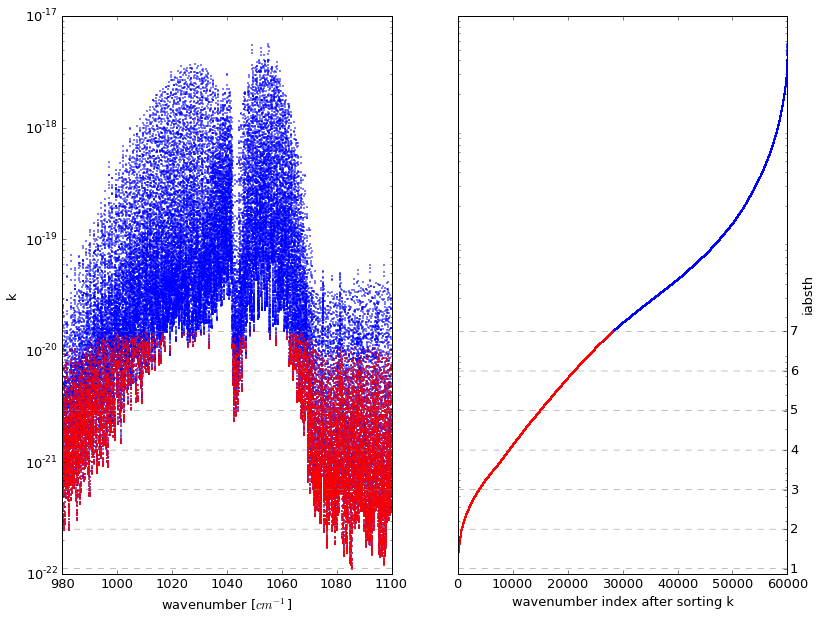

In [55]:
srs = df[ref_pts()['low']]
absth = absth_low


fig, axs, axgs = plt_sorted_series(srs, absth=absth)

# over-plot to indicate wavenumbers in `wvns_low`
srs_sub = srs[wvns_low.index]
axs[0].plot(srs_sub.index, srs_sub.values, 
            color='r', linestyle='None', marker='.', markersize=2)

df_sorted = pd.DataFrame(srs.sort_values())
df_sorted['k-sort index'] = range(srs.shape[0])
df_sorted_sub = df_sorted.loc[wvns_low.index, :]

axs[1].plot(df_sorted_sub['k-sort index'], df_sorted_sub[srs.name].values,
            color='r', linestyle='None', marker='.', markersize=2)

**Figure 2. Absorption coefficient at low reference**  
(left panel) k(pt = pt_low). (right panel) k(pt = pt_low) sorted by k. On the left y-axis are shown the value of the absorption coefficient, k. The horizontal dashed lines mark the g-groups' edges with the g-group number indicated on the right y-axis. Everything above iabsth = 6, for example, belong to g-group 6, and everything below iabsth = 2 belong to g-group 1. The yellow section indicates the wavenumbers where the binning using the low reference will be kept for the final g-groups. The blue section have already been binned using the high reference previously.

In [57]:
# Gather the `ng - ng_low` g-groups first obtained along 
# with these ng_low g-groups to get an overall `ng` g-groups

mem_low = ncut_low[0]
mem_high = ncut_high[0][ncut_high[0] >= g_high_inclusive()]

mem_low = mem_low.astype(np.int64)
mem_high = mem_high.astype(np.int64)


srs_mem = pd.concat([mem_low, mem_high], axis=0,)
srs_mem.sort_index(inplace=True)

In [58]:
# this shows that the union of the two sets of wavenumbers make up
# the original set

set(mem_low.index).union(set(mem_high.index))
set(mem_low.index).intersection(set(mem_high.index))

set()

In [59]:

print('size of union =       ', len(set(mem_low.index).union(set(mem_high.index))))
print('size of intersection =      ', len(set(mem_low.index).intersection(set(mem_high.index))))

size of union =        60000
size of intersection =       0


In [60]:
# Look at relative g-group sizes (or the k-distribution function)

grouped = srs_mem.groupby(srs_mem)
(grouped.size() / grouped.size().sum())

1     0.012533
2     0.049167
3     0.074517
4     0.067633
5     0.057267
6     0.032317
7     0.112350
8     0.128250
9     0.124050
10    0.100333
11    0.078967
12    0.057733
13    0.039117
14    0.023450
15    0.013967
16    0.008683
17    0.006917
18    0.005983
19    0.004600
20    0.002167
dtype: float64

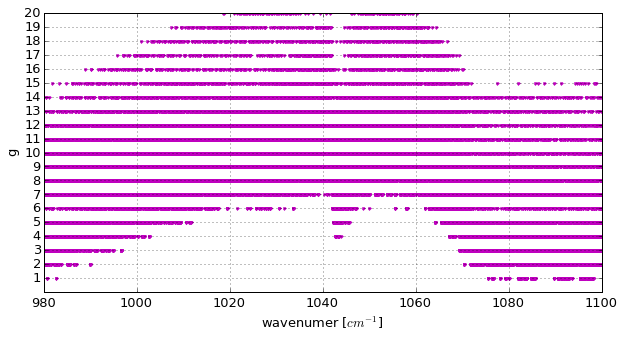

In [62]:
ng = ng_tot()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
ax.plot(srs_mem.index, srs_mem.values, 
        color='m', linestyle='None', marker='.')

ax.grid(b=True)

ax.set_yticks(range(1, ng + 1))
ax.set_yticklabels(range(1, ng + 1))
ax.set_ylabel('g')

ax.set_xlabel('wavenumer [$cm^{-1}$]')

**Figure 3. G-group membership function.**  
The plot shows the g-group that a wavenumber belongs to.  

In [105]:
def plt_tworef_kdist(df, absth_high, absth_low):
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(25, 8))
    
    
    for (ax, ax_sorted), reflev in zip([axs[:2], axs[2:]],
                                       ['high', 'low']):
        
        srs = df[ref_pts()[reflev]]
        
        ax.plot(srs.index, srs.values,
                linestyle='None', marker='.', markersize=2)
        
        ax_sorted.plot(srs.sort_values().values,
                       linestyle='None', marker='.', markersize=2)
        
        
    
    
    axgs = [ax.twinx() for ax in axs]
    axgs[0].get_shared_y_axes().join(*(list(axs) + list(axgs)))
    
    for (ax, ax_sorted), absth, reflev in zip([axgs[:2], axgs[2:]],
                                              [absth_high, absth_low],
                                              ['high', 'low']):
        srs = df[ref_pts()[reflev]]
        
        for v in absth:
            ax.plot(srs.index, v * np.ones(srs.shape),
                    color='grey', linestyle='--', linewidth=.5)
            
            ax_sorted.plot(v * np.ones(srs.shape),
                           color='grey', linestyle='--', linewidth=.5)
        
    
    [ax.set_yscale('log') for ax in list(axs) + list(axgs)]
    
    [ax.yaxis.set_tick_params(size=0) for ax in axs[1:]]
    [plt.setp(ax.get_yticklabels(), visible=False) for ax in axs[1:]]
    
    [ax.yaxis.set_tick_params(size=0) for ax in axgs[:-1]]
    [plt.setp(ax.get_yticklabels(), visible=False) for ax in axgs[:-1]]
    
    axgs[0]
    axgs[1].set_yticks(absth_high)
    axgs[1].set_yticklabels(range(1, absth_high.shape[0] + 1))
    axgs[3].set_yticks(absth_low)
    axgs[3].set_yticklabels(range(1, absth_low.shape[0] + 1))
    
    
    return fig, axs

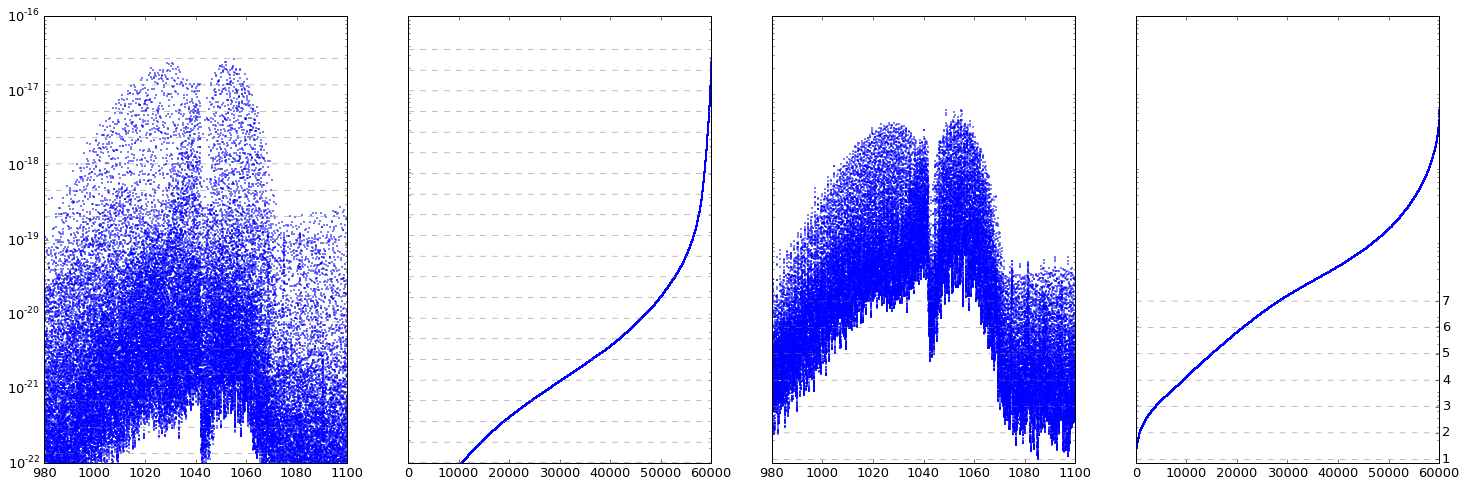

In [106]:
fig, axs = plt_tworef_kdist(df, absth_high, absth_low)

In [107]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
